# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
# Load environment variables
%load_ext dotenv
%dotenv 

# Add src to path
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))

# Standard libraries
import pandas as pd
import numpy as np


In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()
fires_dt.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Get X and Y

Create the features data frame and target data.

In [3]:
# Select all columns except 'area' as features

X = fires_dt.drop(columns='area')

# Select the area column as target.
Y = fires_dt['area']


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [4]:
# Import tools for building machine learning pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Import preprocessing methods: scaling, encoding, transformations
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer

# Import imputers for handling missing values
from sklearn.impute import SimpleImputer

# Import functions for splitting data and model evaluation
from sklearn.model_selection import train_test_split, cross_validate

# Import regression models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression



In [5]:
# Define numeric and categorical feature lists
num_cols_transform = ['coord_x', 'coord_y','ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_cols = ['month', 'day']

# Pipeline for numeric columns: fill missing values with median, then scale
pipe_num_simple = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('standardizer', StandardScaler())
])

# Combine numeric and categorical preprocessing steps
preproc1 = ColumnTransformer([
    ('numeric_simple', pipe_num_simple, num_cols_transform),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='drop') 


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [6]:
# Pipeline for numeric columns: impute, scale, then apply Yeo-Johnson transformation
pipe_num_yj = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('standardizer', StandardScaler()),
    ('transform', PowerTransformer(method='yeo-johnson'))
])

# Preprocessor with numeric (Yeo-Johnson) and categorical transformations
preproc2 = ColumnTransformer([
    ('numeric_simple', pipe_num_yj, num_cols_transform),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='drop')  


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [7]:
# Pipeline A = preproc1 + baseline
pipe_A = Pipeline([
    ('preprocess', preproc1),
    ('regressor', LinearRegression())
])
pipe_A

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric_simple',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', LinearRegression())])

In [8]:
# Pipeline B = preproc2 + baseline
pipe_B = Pipeline([
    ('preprocess', preproc2),
    ('regressor', DecisionTreeRegressor(criterion = 'squared_error', max_depth=3, random_state=42))
])
pipe_B

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric_simple',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

In [9]:
# Pipeline C = preproc1 + advanced model
pipe_C = Pipeline([
    ('preprocess', preproc1),
    ('regressor', RandomForestRegressor(n_estimators=200, criterion = 'squared_error', max_depth=3, random_state=42))
])
pipe_C

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric_simple',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=3, n_estimators=200,
                                       random_state=42))])

In [10]:
# Pipeline D = preproc2 + advanced model
pipe_D = Pipeline([
    ('preprocess', preproc2),
    ('regressor', RandomForestRegressor(n_estimators=200, criterion = 'squared_error', max_depth=3, random_state=42))
])
pipe_D
    

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric_simple',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardizer',
                                                                   StandardScaler()),
                                                                  ('transform',
                                                                   PowerTransformer())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=3, n_estimators=200,
                                       random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [11]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define evaluation metrics for cross-validation
scoring = {
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}


In [12]:
from sklearn.model_selection import GridSearchCV

#Parameter grid for decision tree regressor
param_grid_lr = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [False, True]
}


grid_search_A = GridSearchCV(
    estimator=pipe_A,
    param_grid=param_grid_lr,
    scoring=scoring,
    refit='mse',
    cv=5
)
grid_search_A.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numeric_simple',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardizer',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False],
                         'regressor__positive': [False, True]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error', 'r2': 'r2'})

In [13]:
# Get cross-validation results as a dictionary
res_A = grid_search_A.cv_results_

# Convert results to DataFrame for easier analysis
res_A = pd.DataFrame(res_A)

# View available result columns
res_A.columns



Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_regressor__fit_intercept', 'param_regressor__positive', 'params',
       'split0_test_mse', 'split1_test_mse', 'split2_test_mse',
       'split3_test_mse', 'split4_test_mse', 'mean_test_mse', 'std_test_mse',
       'rank_test_mse', 'split0_test_mae', 'split1_test_mae',
       'split2_test_mae', 'split3_test_mae', 'split4_test_mae',
       'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_r2',
       'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2',
       'mean_test_r2', 'std_test_r2', 'rank_test_r2'],
      dtype='object')

In [14]:
# Show best hyperparameters found by grid search
grid_search_A.best_params_


{'regressor__fit_intercept': False, 'regressor__positive': True}

In [15]:
# Grid search with cross-validation for Decision Tree (pipeline B)
grid_search_B = GridSearchCV(
    estimator=pipe_A,
    param_grid=param_grid_lr,
    scoring=scoring,
    refit='mse',
    cv=5                       
)

# Fit model on training data
grid_search_B.fit(X_train, Y_train)

# Get cross-validation results and convert to DataFrame
res_B = grid_search_B.cv_results_
res_B = pd.DataFrame(res_B)

# Show best hyperparameters found by grid search
grid_search_B.best_params_


{'regressor__fit_intercept': False, 'regressor__positive': True}

In [16]:

# Parameter grid for Random Forest Regressor
param_grid_rf = { 
    'regressor__n_estimators': [100, 200],   
    'regressor__max_depth': [None, 5, 10],  
    'regressor__min_samples_split': [2, 5]  
}

# Grid search with cross-validation for Random Forest
grid_search_C = GridSearchCV(
    estimator=pipe_C,           
    param_grid=param_grid_rf,   
    cv=5,                       
    scoring=scoring,            
    refit='mse'                 
)

# Fit model on training data
grid_search_C.fit(X_train, Y_train)

# Get cross-validation results and convert to DataFrame
res_C = grid_search_C.cv_results_
res_C = pd.DataFrame(res_C)

# View available result columns
res_C.columns

# Show best hyperparameters found by grid search
grid_search_C.best_params_


{'regressor__max_depth': 5,
 'regressor__min_samples_split': 5,
 'regressor__n_estimators': 100}

In [17]:

# Grid search with cross-validation for Random Forest (pipeline D)
grid_search_D = GridSearchCV(
    estimator=pipe_D,           
    param_grid=param_grid_rf,   
    cv=5,                       
    scoring=scoring,           
    refit='mse'                 
)

# Fit model on training data
grid_search_D.fit(X_train, Y_train)

# Get cross-validation results and convert to DataFrame
res_D = grid_search_D.cv_results_
res_D = pd.DataFrame(res_D)

# View available result columns
res_D.columns

# Show best hyperparameters found by grid search
grid_search_D.best_params_


{'regressor__max_depth': 5,
 'regressor__min_samples_split': 5,
 'regressor__n_estimators': 100}

In [18]:
# Create summary DataFrame comparing all pipelines (A–D)

summary = pd.DataFrame([
    {
        'Pipeline': 'A',
        'Best Params': grid_search_A.best_params_,
        'Best MSE': -grid_search_A.best_score_,
        'Best MAE': res_A.loc[grid_search_A.best_index_, 'mean_test_mae'],
        'Best R²':  res_A.loc[grid_search_A.best_index_, 'mean_test_r2']
    },
    {
        'Pipeline': 'B',
        'Best Params': grid_search_B.best_params_,
        'Best MSE': -grid_search_B.best_score_,
        'Best MAE': res_B.loc[grid_search_B.best_index_, 'mean_test_mae'],
        'Best R²':  res_B.loc[grid_search_B.best_index_, 'mean_test_r2']
    },
    {
        'Pipeline': 'C',
        'Best Params': grid_search_C.best_params_,
        'Best MSE': -grid_search_C.best_score_,
        'Best MAE': res_C.loc[grid_search_C.best_index_, 'mean_test_mae'],
        'Best R²':  res_C.loc[grid_search_C.best_index_, 'mean_test_r2']
    },
    {
        'Pipeline': 'D',
        'Best Params': grid_search_D.best_params_,
        'Best MSE': -grid_search_D.best_score_,
        'Best MAE': res_D.loc[grid_search_D.best_index_, 'mean_test_mae'],
        'Best R²':  res_D.loc[grid_search_D.best_index_, 'mean_test_r2']
    }
])


# Display performance comparison of all pipelines
summary

,Pipeline,Best Params,Best MSE,Best MAE,Best R²
0,A,"{'regressor__fit_intercept': False, 'regressor...",2170.804682,-17.617858,-0.214326
1,B,"{'regressor__fit_intercept': False, 'regressor...",2170.804682,-17.617858,-0.214326
2,C,"{'regressor__max_depth': 5, 'regressor__min_sa...",2701.565370,-19.130595,-1.466895
3,D,"{'regressor__max_depth': 5, 'regressor__min_sa...",2645.978700,-18.903569,-1.198031


# Evaluate

+ Which model has the best performance? Performance of A and B were the same but better than C and D. 

# Export

+ Save the best performing model to a pickle file.

In [19]:
import pickle
best_model_A = grid_search_A.best_estimator_

with open("best_model_A.pkl", "wb") as f:
    pickle.dump(best_model_A, f)


In [20]:
with open("best_model_A.pkl", "rb") as f:
    model = pickle.load(f)

model.predict(X_test)


array([ 45.77965253,  20.95983644,  27.53304779,   5.9446259 ,
        15.05953265,   1.18113444,   9.43382919,   4.25977723,
         8.85673267,   0.16444703,   7.46069763,   8.80411268,
        21.04505364,   7.95311369,  18.59721028,   8.89848156,
       -11.24678505,  11.31812322,  13.94893057,   4.38166446,
         3.68925924,  27.1981937 ,  17.1682246 ,  12.17099988,
         2.05796639,  25.19768033,  15.69560003,  30.79354808,
        15.30097478,  10.68413076,  11.50592941,  22.3822487 ,
         8.02357496,  19.72728476,   2.74952683,  17.74968493,
         7.89387829,  14.5827969 ,   9.31354383,  -3.43001851,
        31.20377118,   3.62552566,   3.66765888,  25.33627653,
        16.04533649,  17.79231398,  -7.77354782,   5.99295028,
        16.83811651,  12.81853056,   9.39215905,  22.7961439 ,
        15.97237283,  -2.25758495,  18.84472388,   3.70230726,
         8.11132981,  20.01548213,  14.01963285,   5.89501136,
         7.35381779,   5.84621222,  14.45207747,  -1.60

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [21]:
import shap
best_pipe_A = grid_search_A.best_estimator_
data_transform = best_pipe_A.named_steps['preprocess'].transform(X_test)

explainer = shap.explainers.Linear(
    best_pipe_A.named_steps['regressor'], 
    data_transform,
    feature_names = best_pipe_A.named_steps['preprocess'].get_feature_names_out())

shap_values = explainer(data_transform)


c:\Users\blamo\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


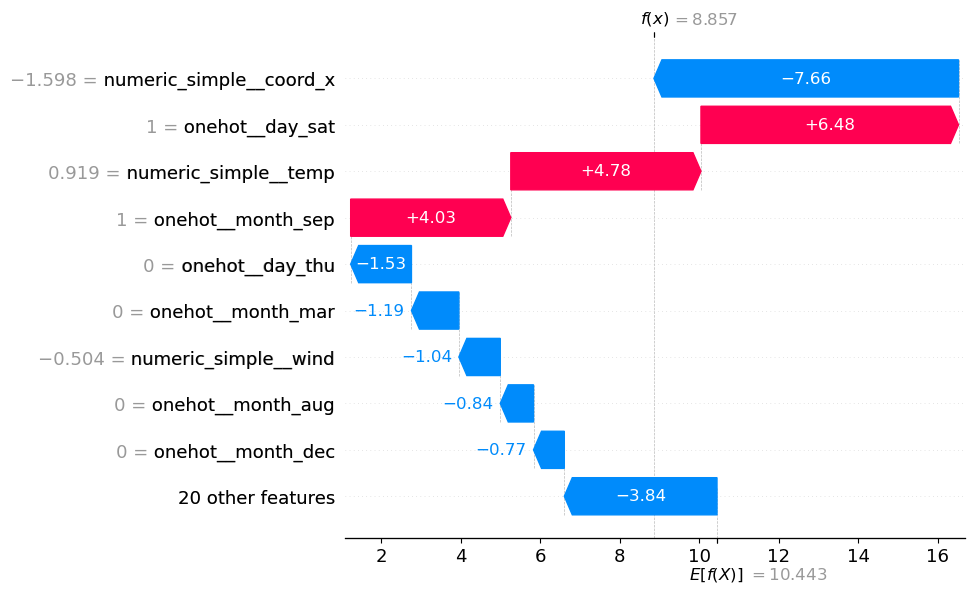

In [22]:
# Visualize SHAP summary
shap.plots.waterfall(shap_values[8])


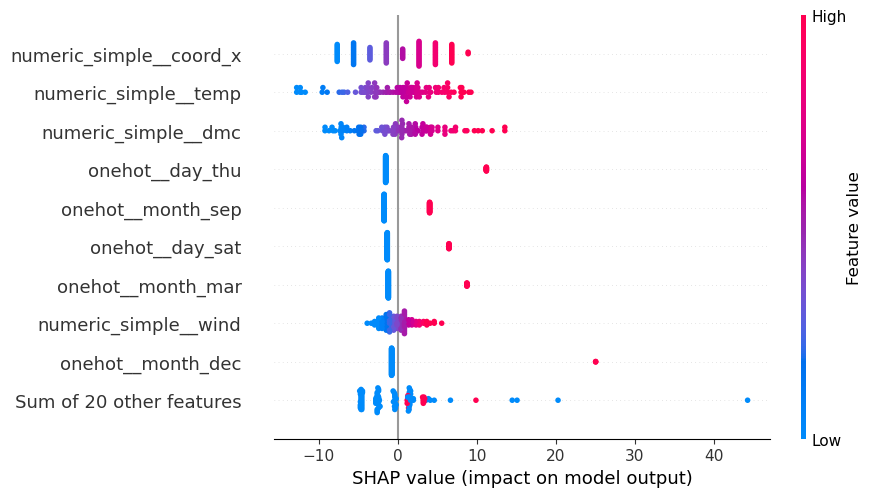

In [23]:
shap.plots.beeswarm(shap_values)

*(Answer here.)*
The baseline prediction for this test set is 10.443.
For observation[8] f(x) = 8.857 which is lower than the baseline.  
The lower value can be explained by the the most important features: a lower numeric_simple_ord_x, a higher one_hot_day_sat and a higher numeric_simple_temp. 

On a global level the most important feature was  numeric_simple_cord_x, which the onhot_month_dec having the lowest importance as a feature.

Features like onehot_month_dec that have a lower overall importance can be removed. To evaluate the impact of the features we would have to exclude the feature, retrain the model and recalculate the scoring metrics. If there is an improvement the scoring metrics then the model performance has been enhanced. If it gets worsts then the feature is still useful to the model. 

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.